#  Aperture photometry on MIRI stage-2 images

**Author**: Mattia Libralato, ESA/AURA Astronomer
<br>
**Last Updated**: July, 2021

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#imports)<br>
    2.2 [Plot configuration](#plot)<br>
    2.3 [Useful functions](#func)<br>
    2.4 [Setup PSF FWHM](#fwhm)<br>
    2.5 [Download data](#download)<br>
3. [A first glimpse to the MIRI data](#datalook)<br>
    3.1 [Data Quality (DQ) flags](#dqflag)<br>
4. [From the image to the astro-photometric catalog](#work)<br>
    4.1 [Sky background](#sky)<br>
    4.2 [Aperture photometry](#phot)<br>
    4.3 [From pixel to equatorial coordinates](#wcs)<br>
    4.4 [Photometric calibration](#cal)<br>
5. [Exercise](#exercise)<br>
6. [Bonus \#1: your first JWST mid-infrared color-magnitude diagram](#bonus1)<br>
7. [Bonus \#2: concentration indexes](#bonus2)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

In this notebook we provide an overview on aperture photometry with simulated images obtained with the Mid-Infrared Instrument ([MIRI](https://jwst-docs.stsci.edu/mid-infrared-instrument)) onboard the James Webb Space Telescope (JWST).

Images were simulated using [MIRISim](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim) and processed through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/). Each exposure was obtained with "FASTR1" readout, 20 groups per integration, and 3 integrations. Simulations were obtained using a [4-point dither pattern](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-operations/miri-dithering/miri-imaging-dithering#MIRIImagingDithering-4point) in F560W and F770W filters. The astronomical scene we will analyze is an homogeneous, mildly-crowded stellar field with a few background galaxies. The stellar population resambles that of a globular cluster; galaxies present random morphologies and fluxes. This mix of objects should provide a good benchmark for testing any photometric tools while waiting for real data.

In this notebook, we use *cal.fits* files. These images are the outputs of the [Stage 2](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image2.html) pipeline. The Stage 2 pipeline takes in the slope images output from the [Stage 1](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html) pipeline and applies instrumental corrections and calibrations.

At the end of this notebook, we should have learned (or refreshed our memory) on aperture photometry and on the MIRI imager.

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all necessary python packages, define some useful functions that will help us later during the analysis, read a table with the encircled-energy values for some MIRI filters, and finally download the simulated MIRI images.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="imports"></a> ###

In [33]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
import astropy.units as u
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
from astropy.nddata import Cutout2D
#
# JWST models
#
from jwst import datamodels, associations
from jwst.datamodels import ImageModel, dqflags
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Use 90% of the window width
#
from IPython.core.display import display, HTML

from jdaviz import Imviz
display(HTML("<style>.container { width:90% !important; }</style>"))

2022-04-15 05:22:36,694 - stpipe - WARNING - /var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_65308/3335716060.py:51: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



### 2.2<font color='white'>-</font>Plot configuration<a class="anchor" id="plot"></a> ###

<div class="alert alert-block alert-warning">
    <h3><u><b>Warning</b></u></h3>

If the plots in this notebook do not render properly, you may need to install LaTeX. Find more information on a system-wide installation [here](https://www.latex-project.org/get/) and on a Jupyter-specific nbextension [here](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html).
</div>

In [2]:
%matplotlib inline
# Figure size
plt.rcParams['figure.figsize'] = [15, 15]
# Figure text and font
plt.rc('text', usetex=True)
plt.rc('font', size=15)

### 2.3<font color='white'>-</font>Useful functions<a class="anchor" id="func"></a> ###

Here you can find some convenient functions:

In [3]:
def imshow_me_wcolorbar(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to show an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots()
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    plt.tight_layout()
    
    return

In [4]:
def imshow_me_wcolorbar_setup(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to setup an image to show. Similar to imshow_me_wcolorbar,
    but it does not show the image directly, thus allowing to plot
    something else after the call.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    
    return

In [5]:
def imshow_cutouts(img, tab, id_sel, xlabel, ylabel, cmap):
    '''
    Function to show four cutouts from an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    tab : Table
        The table with at least (x,y,id) columns.
    id_sel : array(int)
        The ID of the sources in tab to show in the cutouts.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots(2, 2)

    x, y = tab['x'][tab['id'] == id_sel[0]], tab['y'][tab['id'] == id_sel[0]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[0, 0].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[0, 0].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[0, 0].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction',
                      horizontalalignment='center', verticalalignment='center')
    ax[0, 0].set_xlabel(r'{0}'.format(xlabel))
    ax[0, 0].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[1]], tab['y'][tab['id'] == id_sel[1]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[0, 1].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[0, 1].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[0, 1].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[0, 1].set_xlabel(r'{0}'.format(xlabel))
    ax[0, 1].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[2]], tab['y'][tab['id'] == id_sel[2]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[1, 0].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[1, 0].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[1, 0].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[1, 0].set_xlabel(r'{0}'.format(xlabel))
    ax[1, 0].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[3]], tab['y'][tab['id'] == id_sel[3]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[1, 1].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[1, 1].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[1, 1].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[1, 1].set_xlabel(r'{0}'.format(xlabel))
    ax[1, 1].set_ylabel(r'{0}'.format(ylabel))
    
    plt.tight_layout()
    
    return

In [6]:
def arcsec2pix(x):
    '''
    Function that converts arcsec in MIRIM pixels.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in arcsec.
        
    Outputs
    ----------
    The value(s) in MIRIM pixel.
    '''
    
    return x/0.11

In [7]:
def pix2arcsec(x):
    '''
    Function that converts MIRIM pixels in arcsec.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in MIRIM pixels.
        
    Outputs
    ----------
    The value(s) in arcsec.
    '''
    
    return x*0.11

These last three functions will be used to speed-up the exercise.

In [8]:
def prepare_image(img_name):
    '''
    Function that reads one image, flag all pixels with DQ flags different 
    from [0, 2, 4, 6] and adds a random background gradient.
    To be used in the exercise.
    
    Inputs
    ----------
    img_name : string
        The name of the image.
        
    Outputs
    ----------
    img : ImageModel
        The data model of the image.
    img_mod : 2D numpy.ndarray
        The image data with the additional random background gradient.
    '''
    
    img = datamodels.open(img_name)
    ok = np.zeros(img.data.shape, dtype='int')
    for v in [0, 2, 4, 6]:
        ok = ok + np.where(img.dq == v, 1, 0)

    img.data[ok == 0] = np.nan
    
    x = np.linspace(0, 1, img.meta.subarray.xsize)
    y = np.linspace(0, 1, img.meta.subarray.ysize)
    X, Y = np.meshgrid(x, y)
    if (np.random.rand(1) > 0.5):
        sx = +1
    else:
        sx = -1
    if (np.random.rand(1) > 0.5):
        sy = +1
    else:
        sy = -1
    Z = (10*(np.random.rand(1)-0.5))*np.exp(sx*X/(4+2*(np.random.rand(1)-0.5)))*np.exp(sy*Y/(4+4*(np.random.rand(1)-0.5)))
    
    img_mod = img.data.copy() + Z
    
    _, sky_med, sky_sig = sigma_clipped_stats(img_mod[np.isfinite(img_mod)], sigma=5.0, maxiters=5)
    
    print('')
    print(r' Suggested min value: {0}'.format(sky_med-sky_sig))
    print(r' Suggested max value: {0}'.format(sky_med+sky_sig))
    print('')

    cmin = sky_med-sky_sig
    cmax = sky_med+sky_sig
    
    return img, img_mod, cmin, cmax

In [9]:
def prepare_table(img, xy_tmp, aperture_radius, sky, flux, rad_label):
    '''
    Function that performs additional steps discussed in the notebook.
    To be used in the exercise.
    
    Inputs
    ----------
    img : ImageModel
        The data model of the image.
    xy_tmp : Table
        The table created by DAOStarFinder with the sources detected
        in the image.
    aperture_radius : float
        The aperture radius used for the aperture photometry.
    sky : array(float)
        The array with the local sky background for each source.
    flux : array(float)
        The array with the sky-subtracted flux for each source.
    rad_label : string
        The label for the photometry in the Table.
        
    Outputs
    ----------
    aperture_table : Table
        The final astro-photometric table.
    '''
    
    aperture_table = Table()

    aperture_table['x'] = xy_tmp['xcentroid']
    aperture_table['y'] = xy_tmp['ycentroid']
    aperture_table['sharpness'] = xy_tmp['sharpness']
    aperture_table['roundness1'] = xy_tmp['roundness1']
    aperture_table['roundness2'] = xy_tmp['roundness2']

    aperture_table['id'] = xy_tmp['id']
    
    aperture_table['local_sky_' + rad_label] = sky
    aperture_table['aperture_' + rad_label + '_skysub'] = flux
    
    keep_good = np.logical_and(np.isfinite(aperture_table['aperture_' + rad_label + '_skysub']), 
                               aperture_table['aperture_' + rad_label + '_skysub'] > 0.)
    aperture_table = aperture_table[keep_good]
        
    aperture_table['mag_' + rad_label] = -2.5*np.log10(aperture_table['aperture_' + rad_label + '_skysub'])

    aperture_table['flag_' + rad_label] = np.zeros(len(aperture_table), dtype=int)
    for s in aperture_table:
        jmin = max(1, int(np.floor(s['y']-aperture_radius)))
        jmax = min(round(s['y']+aperture_radius)+1, img.shape[0])
        imin = max(1, int(np.floor(s['x']-aperture_radius)))
        imax = min(round(s['x']+aperture_radius)+1, img.shape[1])
        if (np.sum(img.dq[jmin:jmax, imin:imax] == 6) > 0):
            s['flag_' + rad_label] = 6
        elif (np.sum(img.dq[jmin:jmax, imin:imax] == 2) > 0):
            s['flag_' + rad_label] = 2
        elif (np.sum(img.dq[jmin:jmax, imin:imax] == 4) > 0):
            s['flag_' + rad_label] = 4       

    aperture_table['ra'] = aperture_table['x']
    aperture_table['dec'] = aperture_table['y']
    for a in aperture_table:
        rd = img.meta.wcs.transform("detector", "world", a['x'], a['y'])    
        a['ra'] = rd[0]
        if (a['ra'] > 180):
            a['ra'] -= 360.0
        a['dec'] = rd[1]
        
    return aperture_table

In [10]:
def prepare_phot_cal(cat_name, tmp, sel_radius):
    '''
    Function that cross-matches two catalogs and plot the positional residuals.
    To be used in the exercise.
    
    Inputs
    ----------
    cat_name : string
        The name of the pipeline source catalog
    tmp : Table
        The astro-photometric table.
    sel_radius : float
        The radius for the positional-residual selection in arcsec.
        
    Outputs
    ----------
    calib_cat : Table
        The pipeline source catalog.
    ind_i2d_cat: array(int)
        The array with the indexes from match_sky_coordinates.
    dist_2d: array(float)
        The array with the 2D distances from match_sky_coordinates.
    '''
    
    calib_cat = Table.read(cat_name)

    coord_cal = SkyCoord(ra=tmp['ra'], dec=tmp['dec'], unit="deg")
    coord_i2d = SkyCoord(ra=calib_cat['sky_centroid'].ra.degree, dec=calib_cat['sky_centroid'].dec.degree, unit="deg")
    ind_i2d_cat, dist_2d, a = match_coordinates_sky(coord_cal, coord_i2d)

    delta_ra = 3600.0*(tmp['ra']*np.cos(np.deg2rad(tmp['dec'])) - 
                       calib_cat[ind_i2d_cat]['sky_centroid'].ra.degree * 
                       np.cos(np.deg2rad(calib_cat[ind_i2d_cat]['sky_centroid'].dec.degree)))

    delta_dec = 3600.0*(tmp['dec']-calib_cat[ind_i2d_cat]['sky_centroid'].dec.degree)

    fig, ax = plt.subplots()
    ax.scatter(delta_ra, delta_dec, lw=0.5, s=5, color='black', marker='o')
    circle = plt.Circle((0, 0), sel_radius, color='r', fill=False)
    ax.add_patch(circle)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.axhline(0, color='red', ls='--')
    ax.axvline(0, color='red', ls='--')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [arcsec]}$')
    ax.set_ylabel(r'$\Delta\textrm{Dec. [arcsec]}$')

    ax2 = ax.secondary_xaxis('top', functions=(arcsec2pix, pix2arcsec))
    ax2.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [MIRIM pixel]}$')
    ay2 = ax.secondary_yaxis('right', functions=(arcsec2pix, pix2arcsec))
    ay2.set_ylabel(r'$\Delta\textrm{Dec. [MIRIM pixel]}$')

    plt.tight_layout()

    return calib_cat, ind_i2d_cat, dist_2d

### 2.4<font color='white'>-</font>Setup PSF FWHM<a class="anchor" id="fwhm"></a> ###

In [11]:
filter_fwhm = {
    'F560W': 1.636,
    'F770W': 2.187
}

### 2.5<font color='white'>-</font>Download data<a class="anchor" id="download"></a> ###

Let's download and organize the data.

In [12]:
folder_path = './data/'

if (folder_path == './'):
    print('')
    print(' Please set another folder that is not the main folder.')
    print('')
    pass
elif os.path.isdir(folder_path):
    print('')
    print(' Images and catalogs should be already in \'' + folder_path + 
          '\'. If not, delete the folder and run this cell again.')
    print('')
    pass
elif (os.path.isfile('./stage2-selected.zip') and 
      os.path.isfile('./stage3-selected.zip')):
    # Extract both zip files if they are present
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)
else:
    # Download the data and extract both zip files
    boxlink = 'https://stsci.box.com/shared/static/8pjjn8nnaf1d1mev98ca9kc6mss7prmt.zip'
    boxfile = 'stage2-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    boxlink = 'https://stsci.box.com/shared/static/qstpome9vb95ay6aqlgvk0wvlku9ihay.zip'
    boxfile = 'stage3-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    # Extract both zip files
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)


 Images and catalogs should be already in './data/'. If not, delete the folder and run this cell again.



In [13]:
filter_names = ['F560W', 'F770W']

img_names = {}
cat_names = {}
for f in filter_names:
    print('')
    print(r'{0}-filter images:'.format(f))
    names = glob.glob(folder_path + 'det_*' + f + '*_cal.fits')
    for n in range(len(names)):
        print(r'     {0}) {1}'.format(n+1, names[n]))
    img_names[f] = names
    names = glob.glob(folder_path + 'complex_*' + f + '*cat*.ecsv')
    cat_names[f] = names
    print('')
    print(r'1 catalog found: {0}'.format(names[0]))


F560W-filter images:
     1) ./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits
     2) ./data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits
     3) ./data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits
     4) ./data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F560W_combined_cat.ecsv

F770W-filter images:
     1) ./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits
     2) ./data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits
     3) ./data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits
     4) ./data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F770W_combined_cat.ecsv


In [ ]:


image_f560w = ImageModel('./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits')
image_f770w = ImageModel('./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits')
file = './data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits'
file = './data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits'

## 3<font color='white'>-</font>A first glimpse to the MIRI data<a class="anchor" id="datalook"></a> ##

Let's have a look at a F560W-filter image. We start by reading our image as a [JWST data model](https://jwst-pipeline.readthedocs.io/en/latest/jwst/datamodels/) and displaying it. Refer to the JWebbinar 1 ([Pipeline Information and Data Products](https://www.stsci.edu/jwst/science-execution/jwebbinars)) material for a detailed description of the JWST data models.

In [27]:
#img_F560W = datamodels.open(img_names['F560W'][1])
img_F560W = datamodels.open('./data/jw01171001001_02101_00004_mirimage_cal.fits')

First, we compute the $\sigma$-clipped median and sigma of the image. These values are then used to set the color scale for the image. Then, we use the function _imshow_me_wcolorbar_ to show the image. This function uses standard matplotlib tools. Note that pixel values are in mega Jansky per steradian (MJy sr$^{-1}$).

In [28]:
_, med, sig = sigma_clipped_stats(img_F560W.data[np.isfinite(img_F560W.data)], sigma=5.0, maxiters=5)

# Inputs: 2D array, min value, max value, title, x-axis label, y-axis label, colorbar label, colormap
imshow_me_wcolorbar(img_F560W.data, med-1*sig, med+1*sig, 'Original image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

### 3.1<font color='white'>-</font>Data Quality (DQ) flags<a class="anchor" id="dqflag"></a> ###

Not all pixels should be used. We can use the Data Quality (DQ) flags to assess whether a pixel can be considered in calculations or not. [Here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags) you can find a description of the DQ flags.

There is no one-size-fits-all solution for selecting pixels using the DQ flags. For this specific exercise, let's keep all pixels with DQ flag equal to:

- 0 = Good pixel
- 2 = Pixel saturated during integration
- 4 = Jump detected during integration
- 6 = Combination of DQ flags 2 and 4

As we can see, the DQ flags can correspond to multiple features. We can use _dqflags.dqflags_to_mnemonics_ to convert the DQ integer values into more user-friendly names:

In [29]:
print(r' DQ flag equal to 2: {0}'.format(dqflags.dqflags_to_mnemonics(2, dqflags.group)))
print(r' DQ flag equal to 4: {0}'.format(dqflags.dqflags_to_mnemonics(4, dqflags.group)))
print(r' DQ flag equal to 6: {0}'.format(dqflags.dqflags_to_mnemonics(6, dqflags.group)))

 DQ flag equal to 2: {'SATURATED'}
 DQ flag equal to 4: {'JUMP_DET'}
 DQ flag equal to 6: {'SATURATED', 'JUMP_DET'}


Let's flag all pixels with a DQ flag different from these four values:

In [41]:
img_F560W.dq

array([[2148794881, 2148794881, 2148794881, ..., 2148794881, 2148794881,
        2148794881],
       [2148794881, 2148794881, 2148794881, ..., 2148794881, 2148794881,
        2148794881],
       [2148794881, 2148794881, 2148794881, ..., 2148794881, 2148794881,
        2148794881],
       ...,
       [2148794881, 2148794881, 2148794881, ..., 2148794881, 2148794881,
        2148794881],
       [2148794885, 2148794885, 2148794885, ..., 2148794881, 2148794881,
        2148794881],
       [2148794881, 2148794881, 2148794881, ..., 2148794881, 2148794881,
        2148794881]], dtype=uint32)

In [42]:
ok = np.zeros(img_F560W.data.shape, dtype='int')
for v in [0, 2, 4, 6]:
#for v in [1]:
    ok = ok + np.where(img_F560W.dq== v, 1, 0)

img_F560W.data[ok == 0] = np.nan
print(r'{0} out of {1} pixels are not usable (~{2:3.1f}%)'.format((ok == 0).sum(), img_F560W.data.shape[0]*img_F560W.data.shape[1], 
                                                                    (ok == 0).sum()/(img_F560W.data.shape[0]*img_F560W.data.shape[1])*100.0)) 

313036 out of 1056768 pixels are not usable (~29.6%)


After masking, the same MIRI image looks different:

In [47]:
imshow_me_wcolorbar(img_F560W.data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

In [45]:
imviz = Imviz()
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [46]:
imviz.load_data(img_F560W.data)
viewer = imviz.default_viewer
viewer.cuts = '99%'

NotImplementedError: Imviz does not support [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

As we can notice, the regions associated to the 4-quadrant phase mask (4QPM) coronagraphs disappeared from the image. The optical system of the 4QPM coronographs is different from that of the imager. Because of the way these optical elements affect the light transmission, the calibration of the 4QPM-coronograph regions is complicated and specific for these coronographs. Therefore, even though photons are detected in the regions of the coronagraphs during standard imaging observations, these regions should not be used while analyzing the Stage-2 image. If you run the _calwebb_image3_ pipeline (or the resample step in _calwebb_image2_), you will notice that the 4QPM regions are missing in the resampled image (_i2d.fits_) as well.

Another feature we can notice is that two columns (# 385 and 386) were flagged. Although a qualitative assessment of the image (for example with ds9) does not show anything particularly different from the other columns, these two columns showed to be coupled and should not be used for science.

## 4<font color='white'>-</font>From the image to the astro-photometric catalog<a class="anchor" id="work"></a> ##

There are various tools that can be used to perform aperture photometry on an image. In the following, we use [_photutils_](https://photutils.readthedocs.io/en/stable/index.html). Refer to the _photutils_ documentation for an extensive description of its tools.

### 4.1<font color='white'>-</font>Sky background<a class="anchor" id="sky"></a> ###

The JWST background is dominated by emissions from the zodiacal cloud of the Solar System, the Milky Way and the telescope itself. See the [official documentation](https://jwst-docs.stsci.edu/jwst-observatory-functionality/jwst-background-model) for a detailed discussion on this topic.

Sky background can be spatially variable in the image and subtracting the simple mean/median of all pixels would leave residuals in the image background. Thus, it is important to properly model and subtract the sky from each image. If dedicated background observations are available for your data set, you can use the pipeline _Background_ step. Otherwise, we can make a sky-background model from the image itself.

The _photutils_ python package provides various options for subtracting [2D background](https://photutils.readthedocs.io/en/stable/background.html). The basic idea is to divide the image in NxM subregions, estimate the background in each region, and finally create the low-resolution background image with a median filter. A detailed description is provided in the [_Background2D_](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D) documentation.

The choice of the input parameters for the _Background2D_ class is delicate. Some of the key input parameters to remember are the following:
- box_size : the size (in pixels) of the box in which to estimate the background;
- filter_size : the size of the window of the 2D median filter applied to the image to obtain the low-resolution background map;
- sigma_clip : the sigma-clipping parameters;
- bkg_estimator : the method used to compute the background;
- coverage_mask : the mask that tells if a pixel should be masked and not used in the computation.

These parameters should be fine tuned for every image according to some characteristics of the scene you are looking at, for example, the size of the sources, level of crowding, background gradient.

Let's create a 2D background model and subtract it from our image:

2022-04-15 05:56:31,046 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/photutils/background/background_2d.py:282: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
  warnings.warn('Input data contains invalid values (NaNs or '



Median background: 9.260727427877695
RMS background: 0.16719402101876746


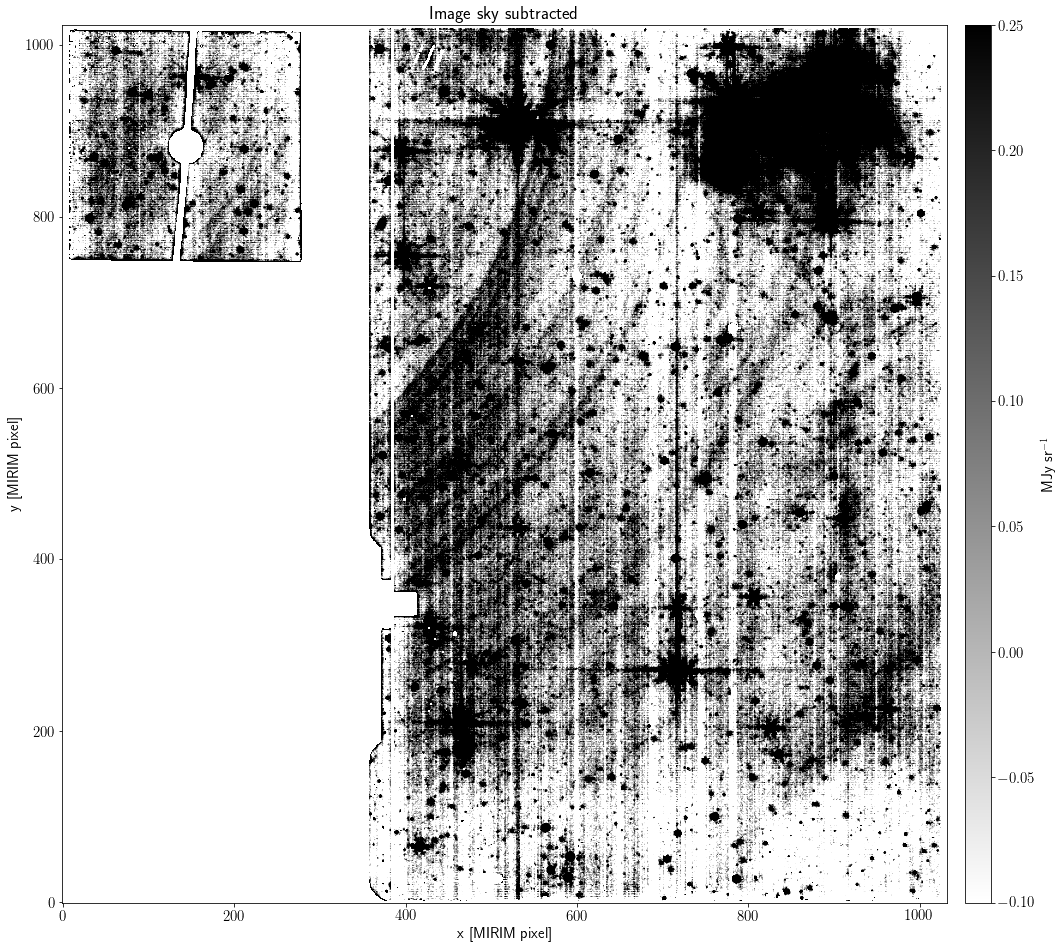

In [48]:
# Mask all nan or inf pixels
mask = np.full(np.shape(img_F560W.data), False, dtype=bool)
mask[np.isnan(img_F560W.data)] = True
mask[~np.isfinite(img_F560W.data)] = True

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
# This is the background estimator -> DAOPHOT MMM algorithm - "mode" = 3*median - 2*mean
mmm_bkg = MMMBackground()
# Compute sky background
sky_F560W = Background2D(img_F560W.data, box_size=(20, 20), filter_size=(30, 30), 
                         sigma_clip=sigma_clip, bkg_estimator=mmm_bkg, coverage_mask=mask, fill_value=0.0)

print(r'Median background: {0}'.format(sky_F560W.background_median))
print(r'RMS background: {0}'.format(sky_F560W.background_rms_median))

img_F560W_skysub = img_F560W.data - sky_F560W.background

imshow_me_wcolorbar(img_F560W_skysub, -0.1, 0.25, 'Image sky subtracted',
                    'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

### 4.2<font color='white'>-</font>Aperture photometry<a class="anchor" id="phot"></a> ###

After we have subtracted the background, we can search for sources in the image using [_DAOStarFinder_](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder), an implementation of the DAOFIND algorithm (<a href="https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract">Stetson 1987, PASP 99, 191</a>).

_DAOStarFinder_ searches an image for local density maxima that have a peak amplitude greater than a specific threshold (applied to a convolved image) and have size and shape similar to a defined 2D Gaussian kernel. For this example, we search for objects at least 5$\times$ above the sky-background rms, and use as FWHM for the 2D Gaussian kernel the FWHM of the PSF in the F560W filter.

In [49]:
# 5 times the background rms
threshold_F560W = 5.0*sky_F560W.background_rms_median

# Filter-dependent FWHM from the PSF
fwhm_F560W = filter_fwhm.get(img_F560W.meta.instrument.filter)

# Create DAOStarFinder instance
dsf_F560W = photutils.DAOStarFinder(threshold=threshold_F560W, fwhm=fwhm_F560W, exclude_border=True)

# Run DAOStarFinder on the subtracted image and save the output in a table
xy_F560W_tmp = dsf_F560W(img_F560W_skysub)

# Print 10 lines of the table
xy_F560W_tmp.pprint_all(max_lines=10)

 id      xcentroid         ycentroid          sharpness           roundness1           roundness2      npix sky        peak               flux                 mag         
---- ----------------- ------------------ ------------------ -------------------- -------------------- ---- --- ------------------ ------------------ ---------------------
   1 602.0989846819033  8.601440278199345 0.6003476211572121   0.3391333430332765  0.24043536051326508   25 0.0 12.637173099572063 13.612717981190839   -2.8348621180014746
   2 776.1347759050007  9.677333468023148 0.5465635896722139 -0.07006691828326582  0.24658243149066583   25 0.0 1.4078432815995967   2.11110410980174    -0.811274128031706
   3 759.4103105841779  12.86064709309187 0.8690590258944283  -0.4326948114194061  -0.2787603417814381   25 0.0 1.3982249747252045 1.3368506360015902   -0.3152072175118015
 ...               ...                ...                ...                  ...                  ...  ... ...                ...          

The column description is almost straightforward. The three parameters that need further description are:
- sharpness : (height of the central pixel - mean of the surrounding non-bad pixels) / (height of the best fitting Gaussian function at that point);
- roundness1 : source symmetry;
- roundness2 : (difference in the height of the best fitting Gaussian function in x - the height of the the best fitting Gaussian function in y) / (average of the best fitting Gaussian functions in x and y).

These parameters can be used to discern between stars, galaxies or spurious detections. It is possible to setup _DAOStarFinder_ to exclude a priori objects outside a specific range of sharpness/roundness1/roundness2. Finally, note that the magnitude is defined as $-2.5\log_{10}(\text{peak density/detection threshold})$, which is just a rough estimate of the magnitude. An exaustive description of inputs and outputs is also provided [here](https://iraf.net/irafhelp.php?val=daofind).

Let's plot what we have found. We can use _imshow_me_wcolorbar_setup_, which is a function similar to _imshow_me_wcolorbar_ we used before but it allows us to keep plotting.

In [50]:
fig, ax = plt.subplots()
imshow_me_wcolorbar_setup(img_F560W_skysub, -0.1, 0.25, 'Image sky subtracted', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
ax.scatter(xy_F560W_tmp['xcentroid'], xy_F560W_tmp['ycentroid'], lw=0.5, s=15, marker='o', edgecolors='red', facecolors='none')
plt.tight_layout()

Now we can perform our aperture photometry using the [_aperture_photometry_](https://photutils.readthedocs.io/en/latest/aperture.html#aperture-photometry-photutils-aperture) function in _photutils_.

We need to store positions in a Nx2 array, with N being the number of stars found by _DAOStarFinder_. Then, we call _CircularAperture_, which defines a circular aperture for each star at position (x,y). We can define one or more aperture radii. For this example, let's use three radii based on the FWHM of the F560W-filter PSF:

In [51]:
# Define the positions
positions_F560W = np.stack((xy_F560W_tmp['xcentroid'], xy_F560W_tmp['ycentroid']), axis=-1)

# Retrieve the aperture radii based on the FWHM of the F560W-filter PSF
r0 = filter_fwhm.get(img_F560W.meta.instrument.filter)
r1 = filter_fwhm.get(img_F560W.meta.instrument.filter)*2.0
r2 = filter_fwhm.get(img_F560W.meta.instrument.filter)*3.0
aper_radii = [r0, r1, r2]

print(r'Aperture radii used:')
print(r' r0 = {0:.3f} MIRIM pixel'.format(r0))
print(r' r1 = {0:.3f} MIRIM pixel'.format(r1))
print(r' r2 = {0:.3f} MIRIM pixel'.format(r2))
print('')

# Define the circular apertures
circular_apertures = [CircularAperture(positions_F560W, r=r) for r in aper_radii]

# Run the aperture photometry
phot_F560W_tmp = aperture_photometry(img_F560W.data*img_F560W.area, circular_apertures, method='exact')

# Print 10 lines
phot_F560W_tmp.pprint_all(max_lines=10)

Aperture radii used:
 r0 = 2.187 MIRIM pixel
 r1 = 4.374 MIRIM pixel
 r2 = 6.561 MIRIM pixel

 id       xcenter           ycenter         aperture_sum_0     aperture_sum_1    aperture_sum_2  
            pix               pix                                                                
---- ----------------- ------------------ ------------------ ----------------- ------------------
   1 602.0989846819033  8.601440278199345 217.75117994266887 639.6012842072071                nan
   2 776.1347759050007  9.677333468023148 142.81023207156693 540.1897531050358 1197.6108076103092
 ...               ...                ...                ...               ...                ...
 999 419.2426176187304 1013.4872519189145  153.7489481252086 572.8240096256548 1268.1725383784556
1000 776.2020250791517 1014.5235197642988   143.570433918088 556.9577511246332                nan
1001 781.4634473270964 1014.4073837608962  141.0459404187831 552.8915711105197                nan
Length = 1001 rows


The three fluxes are saved in aperture_sum_0, aperture_sum_1 and aperture_sum_2. Positions are exactly the same given in input, i.e., the output of _DAOStarFinder_.

<div class="alert alert-block alert-info">
    <h3><u><b>Note</b></u></h3>

As you can notice, the aperture photometry is performed on the image values multiplied by _img_F560W.area_.

The area subtended by each pixel on the sky varies as a result of geometric distortion and hence, they have different collecting power. Flat-fielding  is designed to produce images with a flat background given a flat stimulus. When the flat-field correction is applied to a science image, the resulting image is characterized by constant surface brightness. However, flat-fielding does not take into account for the different collecting power of pixels due to geometric distortion. For more details, see the discussion <a href="https://hst-docs.stsci.edu/wfc3dhb/chapter-9-wfc3-data-analysis/9-1-wfc3-data-analysis#id-9.1WFC3DataAnalysis-9.1.119.1.11PixelAreaMaps">here</a>.
    
Photometry measured on distorted images as the stage-2 _cal.fits_ files requires a field-dependent correction called the Pixel Area Map (PAM), to ensure that the same sources have the same magnitude regardless of their position within the images. The PAM is obtained from the geometric-distortion correction and is included in the _area_ extention of the JWST data model.

</ul>
</div>

These fluxes obviously include the sky background. Using a global value for the sky is not ideal, even if we work with a sky-subtracted image, because there can be unsubtracted background residuals left. Thus, we evaluate the local background for each source using a [circular annulus](https://photutils.readthedocs.io/en/latest/aperture.html#local-background-subtraction) of inner and outer radii of 25 and 35 MIRIM pixels, respectively. We can also mask pixels before evaluating the local background.

In [52]:
# Define the annulus aperture
annulus_aperture = CircularAnnulus(positions_F560W, r_in=25.0, r_out=35.0)

# Define the mask with only pixels in each annulus
annulus_mask = annulus_aperture.to_mask(method='center')

# The local sky for each star will be stored in this list
local_sky_median = []

# For each source
for mask in annulus_mask:
    # Multiply the pixel values by the mask. Since the mask is either 0 or 1, 
    # the only non-zero pixels are those in the circular annulus
    annulus_data = mask.multiply(img_F560W.data*img_F560W.area)
    
    # Keep only non-masked pixels with finite values
    ok = np.logical_and(mask.data > 0, np.isfinite(annulus_data))
    
    # If there are not at least 10 usable pixels in the annulus to compute
    # the local median sky, flag the star and remove it from the final list later
    if (np.sum(ok) >= 10):
        # From 2D to 1D array
        annulus_data_1d = annulus_data[ok]
        # Sigma-clipped median
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.5, maxiters=5)
    else:
        # Flagged value
        median_sigclip = -99.99
    local_sky_median.append(median_sigclip)
    
# Convert list into array
local_sky_median_F560W = np.array(local_sky_median)

The work is almost complete. We can make some order and save the final astro-photometric catalog.

In [53]:
phot_F560W = Table()

# Useful info from DAOStarFinder
phot_F560W['x'] = xy_F560W_tmp['xcentroid']
phot_F560W['y'] = xy_F560W_tmp['ycentroid']
phot_F560W['sharpness'] = xy_F560W_tmp['sharpness']
phot_F560W['roundness1'] = xy_F560W_tmp['roundness1']
phot_F560W['roundness2'] = xy_F560W_tmp['roundness2']

# Save an ID
phot_F560W['id'] = xy_F560W_tmp['id']

# Local median sky
phot_F560W['annulus_median'] = local_sky_median_F560W

The total background within a circular aperture is the median local background times the area of the circular aperture. The area is saved as an attribute of the circular aperture.

In [54]:
# Aperture photometry with r0
phot_F560W['local_sky_r0'] = local_sky_median_F560W*circular_apertures[0].area
phot_F560W['aperture_r0_skysub'] = phot_F560W_tmp['aperture_sum_0'] - phot_F560W['local_sky_r0']

# Aperture photometry with r1
phot_F560W['local_sky_r1'] = local_sky_median_F560W*circular_apertures[1].area
phot_F560W['aperture_r1_skysub'] = phot_F560W_tmp['aperture_sum_1'] - phot_F560W['local_sky_r1']

# Aperture photometry with r2
phot_F560W['local_sky_r2'] = local_sky_median_F560W*circular_apertures[2].area
phot_F560W['aperture_r2_skysub'] = phot_F560W_tmp['aperture_sum_2'] - phot_F560W['local_sky_r2']

# Print 10 lines
phot_F560W.pprint_all(max_lines=10, max_width=200)

        x                 y              sharpness           roundness1           roundness2       id  ... aperture_r0_skysub    local_sky_r1   aperture_r1_skysub    local_sky_r2    aperture_r2_skysub
----------------- ------------------ ------------------ -------------------- -------------------- ---- ... ------------------ ----------------- ------------------ ------------------ ------------------
602.0989846819033  8.601440278199345 0.6003476211572121   0.3391333430332765  0.24043536051326508    1 ...  84.20951374432397 534.1666647933796 105.43461941382748 1201.8749957851044                nan
776.1347759050007  9.677333468023148 0.5465635896722139 -0.07006691828326582  0.24658243149066583    2 ... 12.088453437005398 522.8871145382461  17.30263856678971  1176.496007711054 21.114799899255104
759.4103105841779  12.86064709309187 0.8690590258944283  -0.4326948114194061  -0.2787603417814381    3 ... 11.069616977776633  526.011981264584 21.316158567125512 1183.5269578453142  34.5706186786

Some stars are close to the edge of the MIRI imager and their flux cannot always be measured. Let's remove these stars:

In [55]:
# Remove stars with flagged sky values
phot_F560W = phot_F560W[phot_F560W['annulus_median'] > -90.0]

# Remove all stars that do not have a finite flux within r0, r1 and r2.
for r in [0, 1, 2]:
    keep_good = np.logical_and(np.isfinite(phot_F560W['aperture_r' + str(r) + '_skysub']), 
                               phot_F560W['aperture_r' + str(r) + '_skysub'] > 0.)
    phot_F560W = phot_F560W[keep_good]

phot_F560W.pprint_all(max_lines=10, max_width=200)

        x                 y              sharpness           roundness1            roundness2       id ... aperture_r0_skysub    local_sky_r1   aperture_r1_skysub    local_sky_r2    aperture_r2_skysub
----------------- ------------------ ------------------ -------------------- --------------------- --- ... ------------------ ----------------- ------------------ ------------------ ------------------
776.1347759050007  9.677333468023148 0.5465635896722139 -0.07006691828326582   0.24658243149066583   2 ... 12.088453437005398 522.8871145382461  17.30263856678971  1176.496007711054 21.114799899255104
759.4103105841779  12.86064709309187 0.8690590258944283  -0.4326948114194061   -0.2787603417814381   3 ... 11.069616977776633  526.011981264584 21.316158567125512 1183.5269578453142  34.57061867862899
 861.219538121508  13.09141640594391 0.7058055324898277   0.2759575404906107 -0.007218231210428123   4 ... 15.935139342464169 525.2195584885502 28.387929316068494 1181.7440065992382  45.9908278152

We can compute the instrumental magnitude for each circular aperture:

In [56]:
phot_F560W['mag_r0'] = -2.5*np.log10(phot_F560W['aperture_r0_skysub'])
phot_F560W['mag_r1'] = -2.5*np.log10(phot_F560W['aperture_r1_skysub'])
phot_F560W['mag_r2'] = -2.5*np.log10(phot_F560W['aperture_r2_skysub'])

At the beginning, we used the DQ flags to mask some pixels and kept only those with DQ$=$0, 2, 4, 6. Although still perfectly usable, you might want to keep track of pixels that saturated during an integration or were hit by a cosmic ray. For this reason, we define a flag by checking all pixels within each aperture radius we used:

In [57]:
phot_F560W['flag_r0'] = np.zeros(len(phot_F560W), dtype=int)
phot_F560W['flag_r1'] = np.zeros(len(phot_F560W), dtype=int)
phot_F560W['flag_r2'] = np.zeros(len(phot_F560W), dtype=int)

for r, rl in zip([r0, r1, r2], ['r0', 'r1', 'r2']):
    for s in phot_F560W:
        jmin = max(1, int(np.floor(s['y']-r)))
        jmax = min(round(s['y']+r)+1, img_F560W.shape[0])
        imin = max(1, int(np.floor(s['x']-r)))
        imax = min(round(s['x']+r)+1, img_F560W.shape[1])
        if (np.sum(img_F560W.dq[jmin:jmax, imin:imax] == 6) > 0):
            s['flag_' + rl] = 6
        elif (np.sum(img_F560W.dq[jmin:jmax, imin:imax] == 2) > 0):
            s['flag_' + rl] = 2
        elif (np.sum(img_F560W.dq[jmin:jmax, imin:imax] == 4) > 0):
            s['flag_' + rl] = 4
            
print('                            Sources found: {0}'.format(len(phot_F560W)))
print('Sources with "SATURATED" pixels within r2: {0}'.format(np.sum(np.logical_or(phot_F560W['flag_r2'] == 2, phot_F560W['flag_r2'] == 6))))
print(' Sources with "JUMP_DET" pixels within r2: {0}'.format(np.sum(np.logical_or(phot_F560W['flag_r2'] == 4, phot_F560W['flag_r2'] == 6))))

                            Sources found: 911
Sources with "SATURATED" pixels within r2: 12
 Sources with "JUMP_DET" pixels within r2: 911


Let's check if our flag works. For example, let's test the jump-detection flag:

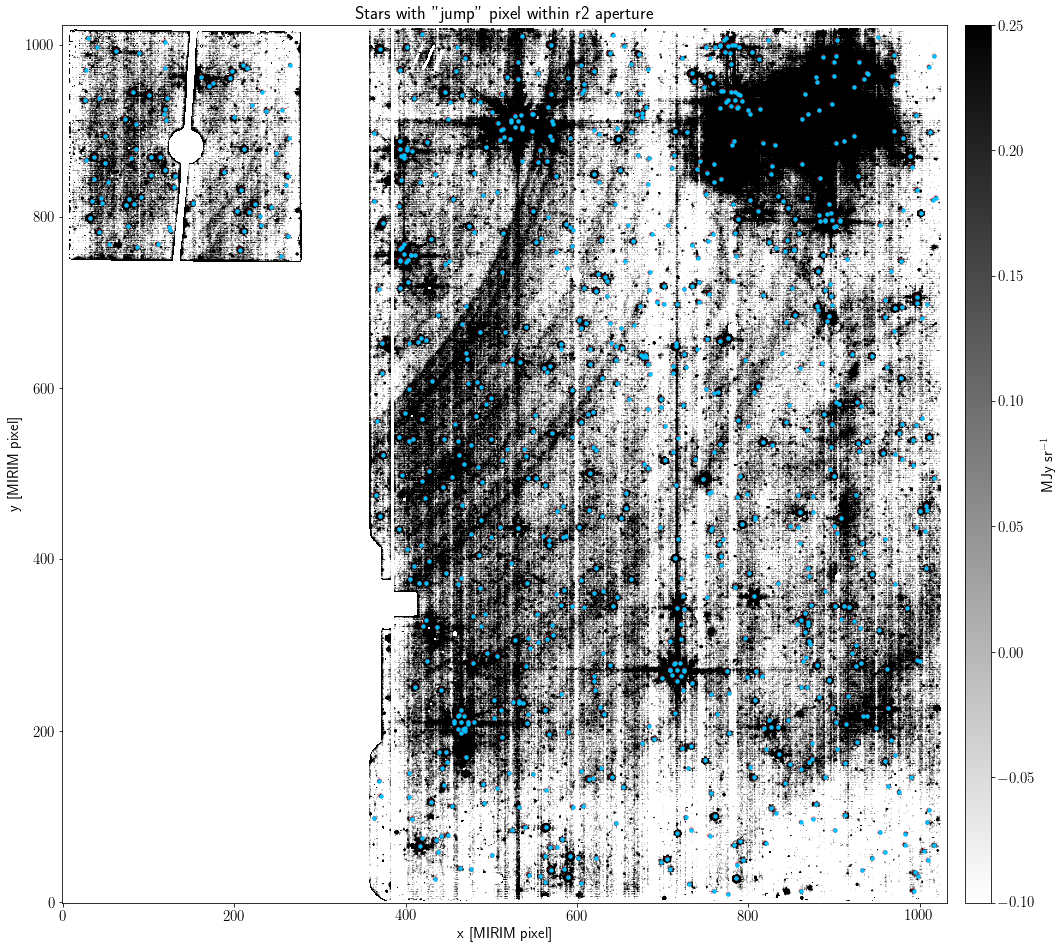

In [58]:
# Flag for stars with "jump" pixel within r2 aperture
jump = np.logical_or(phot_F560W['flag_r2'] == 4, phot_F560W['flag_r2'] == 6)

fig, ax = plt.subplots()
imshow_me_wcolorbar_setup(img_F560W_skysub, -0.1, 0.25, 'Stars with "jump" pixel within r2 aperture', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
ax.scatter(phot_F560W['x'], phot_F560W['y'], lw=0.5, s=15, marker='o', edgecolors='red', facecolors='none')
ax.scatter(phot_F560W['x'][jump], phot_F560W['y'][jump], c='deepskyblue', lw=0, s=20)
plt.tight_layout()

### 4.3<font color='white'>-</font>From pixel to equatorial coordinates<a class="anchor" id="wcs"></a> ###

We can transform the (x,y) positions from the raw, MIRIM coordinate system to the Equatorial system (ICRS) by means of the WCS information stored in the ASDF extension of our image.

<div class="alert alert-block alert-info">
    <h3><u><b>Nota bene</b></u></h3>
    
For stage-2 images (_cal.fits_ files), the WCS information is assigned by the _assign_wcs_ step. This information is saved in an ASDF extension of the FITS file. However, image-display tools such as ds9 do not understand the ASDF encoding. For this reason, an approximation to the WCS is stored in the image header using the SIP (Simple Imaging Polynomial) convention. The SIP-based header does not provide an exact fit: it is accurate to a $\sim$0.25-pixel level and it is meant for general display purposes (see <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html">here</a> for more information).
</ul>
</div>

In [59]:
phot_F560W['ra'] = phot_F560W['x']
phot_F560W['dec'] = phot_F560W['y']
for a in phot_F560W:
    rd = img_F560W.meta.wcs.transform("detector", "world", a['x'], a['y'])    
    a['ra'] = rd[0]
    if (a['ra'] > 180):
        a['ra'] -= 360.0
    a['dec'] = rd[1]

### 4.4<font color='white'>-</font>Plot CMD<a class="anchor" id="cal"></a> ###

Finally, we can make our first mid-infrared color-magnitude diagram:

<hr style="border:1px solid gray"> </hr>

<div class="alert alert-block alert-info">
    <h3><u><b>Aperture photometry on stage-3 images</b></u></h3>
    
This notebook can be adapted to perform aperture photometry on stage-3 (_i2d.fits_) images. In this case, with a few expedients the photometric calibration does not need additional files.
    
First, we choose an aperture radius from the aperture-correction reference file available in the <a href="https://jwst-crds.stsci.edu/">JWST Calibration Reference Data System</a> (CRDS). For each filter (FILTER), array/subarray (PUPIL) and encircled-energy values (EEFRACTION), this file lists the aperture-correction values needed for correcting observed signals within a finite aperture to the estimated total signal for a source (APCORR), the aperture radius containing the EEFRACTION fraction of the total flux (RADIUS), the inner (SKYIN) and outer (SKYOUT) radii for the sky estimation. The APCORR value is a multiplicative correction that scales the measured flux to infinite aperture.

If we perform aperture photometry using these values of RADIUS, SKYIN and SKYOUT, then, once corrected the flux for the finite aperture, the photometric calibration is straighforward. Indeed, as for stage-2 images, the pixel unit in the stage-3 images is MJy sr$^{-1}$. This is an advantage for the photometric calibration because we can directly obtain magnitudes in the AB system (<a href="https://ui.adsabs.harvard.edu/abs/1964ApJ...140..689O/abstract">Oke 1964</a>; see also Sect. 7 of <a href="https://ui.adsabs.harvard.edu/abs/2005PASP..117.1049S/abstract">Sirianni et al. 2005</a>). The AB magnitude is defined as:

\begin{equation*}
    m_{\rm AB} = -2.5 \log_{10} f_\nu - 48.60
\end{equation*}

with $f_\nu$ in erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$, or as:

\begin{equation*}
    m_{\rm AB} = -2.5 \log_{10} f_\nu + 8.90
\end{equation*}

with $f_\nu$ in Jansky. Therefore, we can simply transform our total flux in MJy sr$^{-1}$ by multiplying it by $10^6$ and by the average pixel area in steradian. The header keyword _PIXAR_SR_ contains the average pixel area in steradian; the corresponding value in the JWST data-model scheme is included in _meta.photometry.pixelarea_steradians_. This value is added in the flux (photometric) calibrations performed by the _Photom_ step of the _calwebb_image2_ pipeline.

AB magnitudes can be converted to VEGA magnitudes by adding the AB-to-Vega magnitude offset available in the corresponding reference file in the CRDS.
    
<div class="alert alert-block alert-warning">
    <h3><u><b>Warning 1</b></u></h3>

The APCORR values include a correction for the sky-background subtraction obtained with the specific SKYIN and SKYOUT radii provided in the CRDS reference file. This correction takes into account the contribution of the PSF wings of the star to the local background. If different sky-background radii are used, the APCORR values cannot be used anymore. The best alternative option is to evaluate the sky background in an annulus far enough from the center of each star that the contribution of the PSF wings of the star to the local background is negligible, for example between 25 and 35 pixels as shown in this notebook. In this case, the total flux of a star can be obtained from the flux containging EEFRACTION of the total flux by multiplying it by EEFRACTION$^{-1}$.
</ul>
</div>
    
<div class="alert alert-block alert-warning">
    <h3><u><b>Warning 2</b></u></h3>

No pixel-area map correction is needed with stage-3 images.
</ul>
</div>

</ul>
</div>

## 5<font color='white'>-</font>Exercise<a class="anchor" id="exercise"></a> ##

Let's repeat some steps discussed before for another image in F770W filter. First, let's call this routine to read a new image. For this exercise, a random gradient has been added to the image so we are forced to find the new correct setup for _Background2D_. _This is not how a real image will look like_.

In [69]:
img_F770W, img_F770W_mod, cmin, cmax = prepare_image('./data/jw01171001001_02101_00003_mirimage_cal.fits')


 Suggested min value: 12.117409461767945
 Suggested max value: 13.240230539229078



We can use these parameters as initial guesses for the colorbar.

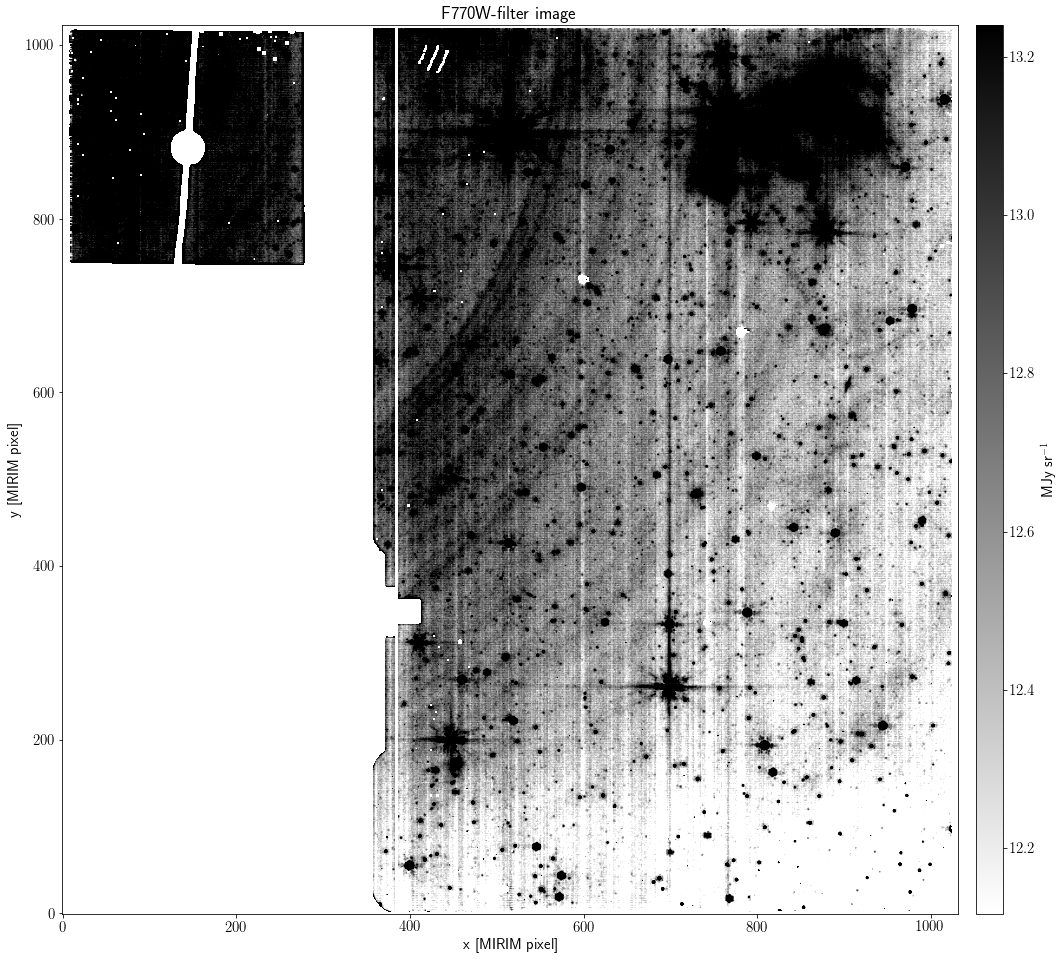

In [70]:
imshow_me_wcolorbar(img_F770W_mod, cmin, cmax, 'F770W-filter image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

The first step we need to do is to subtract the sky background. We are going to use the img_F770W_mod 2D array for this part of the exercise. Try to setup _Background2D_ with the correct parameters.

In [71]:
mask = np.full(np.shape(img_F770W.data), False, dtype=bool)
mask[np.isnan(img_F770W_mod)] = True
mask[~np.isfinite(img_F770W_mod)] = True

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
mmm_bkg = MMMBackground()
# Complete the line below
sky_F770W = Background2D(img_F770W_mod, box_size=(20, 20), filter_size=(10, 10), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg, coverage_mask=mask, fill_value=0.0)

print(r'Median background: {0}'.format(sky_F770W.background_median))
print(r'RMS background: {0}'.format(sky_F770W.background_rms_median))

img_F770W_skysub = img_F770W_mod - sky_F770W.background

imshow_me_wcolorbar(img_F770W_skysub, -0.1, 0.1, 'F770W-filter sky-subtracted image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

2022-04-15 06:11:23,976 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/photutils/background/background_2d.py:282: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
  warnings.warn('Input data contains invalid values (NaNs or '



Median background: 12.71938559483353
RMS background: 0.1686952843297667


Now we can use _DAOStarFinder_ to find sources in our image (keep using the img_F770W_mod 2D array).

In [72]:
threshold_F770W = 5.0*sky_F770W.background_rms_median
fwhm_F770W = filter_fwhm.get(img_F770W.meta.instrument.filter)

dsf = photutils.DAOStarFinder(threshold=threshold_F770W, fwhm=fwhm_F770W, exclude_border=True)
xy_F770W_tmp = dsf(img_F770W_skysub)

xy_F770W_tmp.pprint_all(max_lines=10)

 id     xcentroid         ycentroid          sharpness           roundness1           roundness2      npix sky        peak               flux                mag        
--- ----------------- ------------------ ------------------ -------------------- -------------------- ---- --- ------------------ ------------------ -------------------
  1 853.7589746839819 7.2554801785493375 0.5936696232910454 -0.22070473043318983   0.0438856103743687   25 0.0  8.732339294347494   9.68728866293356 -2.4655056027154836
  2 713.3835788465525 11.105735766898649 0.6039253178494369  -0.2028633668528711 -0.16337001387059388   25 0.0  8.152413891968218   8.82704244727676 -2.3645380375439506
  3 909.3359366852206  10.90412510682681  0.652609669510969  -0.5652401060617546 -0.39560843194996603   25 0.0 1.2953957154868068 1.5204418955196637 -0.4549245700176222
...               ...                ...                ...                  ...                  ...  ... ...                ...                ...       

Now perform aperture photometry on this image using an aperture radius equal to 2$\times$ the PSF FWHM in this filter. We can now use the original img_F770W data model for the remaining parts of the exercise.

In [73]:
positions_F770W = np.stack((xy_F770W_tmp['xcentroid'], xy_F770W_tmp['ycentroid']), axis=-1)

r0 = filter_fwhm.get(img_F770W.meta.instrument.filter)*2.0
circular_apertures = CircularAperture(positions_F770W, r=r0)
phot_F770W_tmp = aperture_photometry(img_F770W.data*img_F770W.area, circular_apertures, method='exact')

annulus_aperture = CircularAnnulus(positions_F770W, r_in=25.0, r_out=35.0)
annulus_mask = annulus_aperture.to_mask(method='center')
local_sky_median = []
for mask in annulus_mask:
    annulus_data = mask.multiply(img_F770W.data*img_F770W.area)
    ok = np.logical_and(mask.data > 0, np.isfinite(annulus_data))
    if (np.sum(ok) >= 10):
        annulus_data_1d = annulus_data[ok]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.5, maxiters=5)
    else:
        median_sigclip = -99.99
    local_sky_median.append(median_sigclip)
local_sky_median_F770W = np.array(local_sky_median)

# Complete the two lines below
sky_F770W = local_sky_median_F770W*circular_apertures.area
flux_F770W = phot_F770W_tmp['aperture_sum'] - sky_F770W

The following function prepares a table similar to the photometric table created for the F560W-filter image.

In [74]:
phot_F770W = prepare_table(img_F770W, xy_F770W_tmp, r0, sky_F770W, flux_F770W, 'r0')

phot_F770W.pprint_all(max_lines=10, max_width=200)

print('')
print('                            Sources found: {0}'.format(len(phot_F770W)))
print('Sources with "SATURATED" pixels within r0: {0}'.format(np.sum(np.logical_or(phot_F770W['flag_r0'] == 2, phot_F770W['flag_r0'] == 6))))
print(' Sources with "JUMP_DET" pixels within r0: {0}'.format(np.sum(np.logical_or(phot_F770W['flag_r0'] == 4, phot_F770W['flag_r0'] == 6))))

        x                 y              sharpness           roundness1           roundness2       id ... aperture_r0_skysub        mag_r0       flag_r0         ra               dec        
----------------- ------------------ ------------------ -------------------- -------------------- --- ... ------------------ ------------------- ------- ----------------- ------------------
853.7589746839819 7.2554801785493375 0.5936696232910454 -0.22070473043318983   0.0438856103743687   1 ...  73.74925517965642  -4.669394096439107       4 80.46128805217138 -69.48615467843206
713.3835788465525 11.105735766898649 0.6039253178494369  -0.2028633668528711 -0.16337001387059388   2 ...   73.3387445803686  -4.663333678484525       4  80.4544528863298 -69.48975370855561
909.3359366852206  10.90412510682681  0.652609669510969  -0.5652401060617546 -0.39560843194996603   3 ...  17.64381436091014  -3.116481199271184       4  80.4643579815132 -69.48482053286112
              ...                ...              

Finally, calibrate the instrumental magnitudes using the pipeline source catalog.

## 6<font color='white'>-</font>Bonus \#1: your first JWST mid-infrared color-magnitude diagram<a class="anchor" id="bonus1"></a> ##

We have built two catalogs for the same field in two filters. We can combine the photometry in these catalogs to create our first mid-infrared color-magnitude diagram.

In [81]:
coord_F560W = SkyCoord(ra=phot_F560W['ra'], dec=phot_F560W['dec'], unit="deg")
coord_F770W = SkyCoord(ra=phot_F770W['ra'], dec=phot_F770W['dec'], unit="deg")
ind_F770W_cat, dist_2d, a = match_coordinates_sky(coord_F560W, coord_F770W)

Let's check the result of the cross-match:

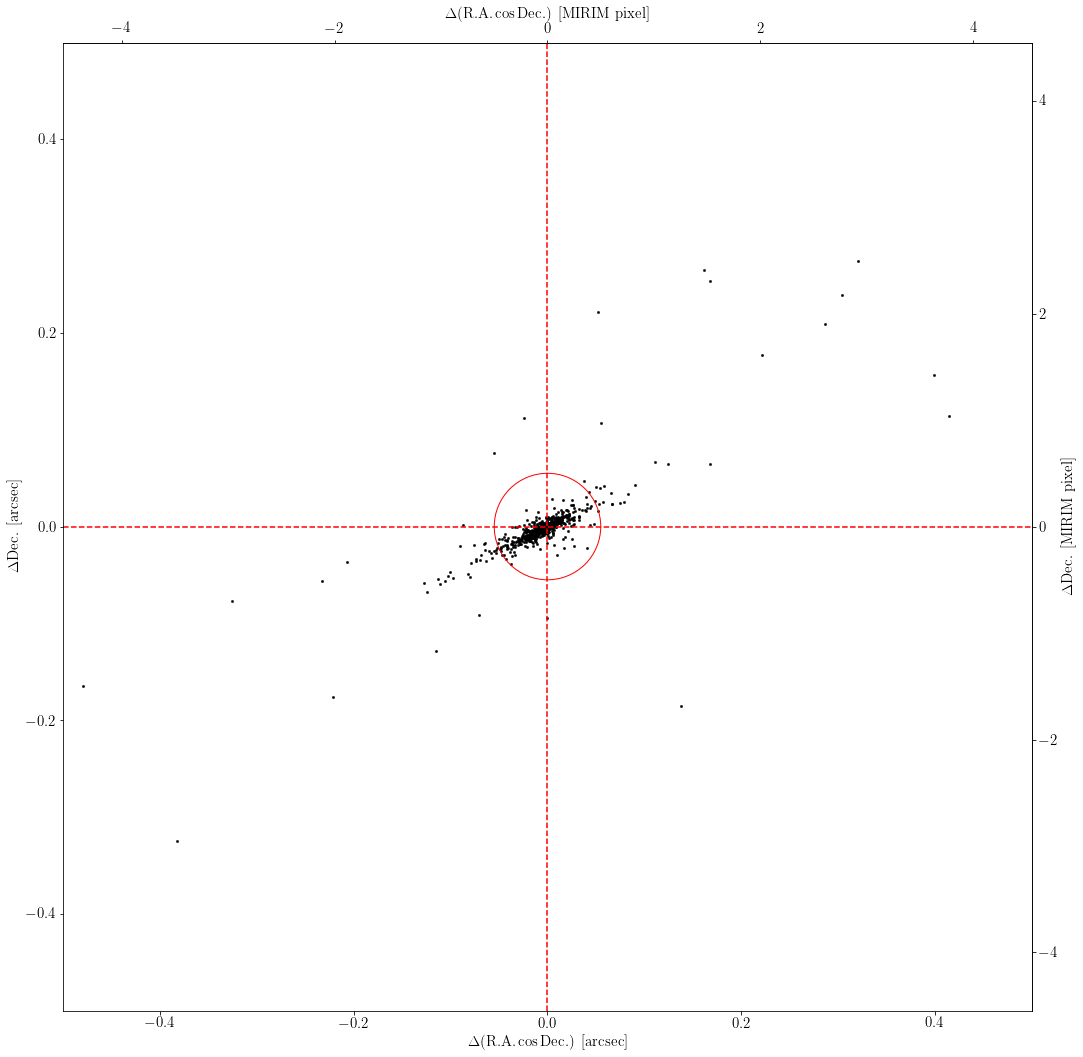

In [82]:
delta_ra = 3600.0*(phot_F560W['ra']*np.cos(np.deg2rad(phot_F560W['dec'])) - 
                   phot_F770W['ra'][ind_F770W_cat]*np.cos(np.deg2rad(phot_F770W['dec'][ind_F770W_cat])))

delta_dec = 3600.0*(phot_F560W['dec']-phot_F770W['dec'][ind_F770W_cat])

fig, ax = plt.subplots()
ax.scatter(delta_ra, delta_dec, lw=0.5, s=5, color='black', marker='o')
circle = plt.Circle((0, 0), 0.055, color='r', fill=False)
ax.add_patch(circle)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.axhline(0, color='red', ls='--')
ax.axvline(0, color='red', ls='--')
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [arcsec]}$')
ax.set_ylabel(r'$\Delta\textrm{Dec. [arcsec]}$')

ax2 = ax.secondary_xaxis('top', functions=(arcsec2pix, pix2arcsec))
ax2.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [MIRIM pixel]}$')
ay2 = ax.secondary_yaxis('right', functions=(arcsec2pix, pix2arcsec))
ay2.set_ylabel(r'$\Delta\textrm{Dec. [MIRIM pixel]}$')

plt.tight_layout()

Let's define as "found" only objects with a positional rms lower than 0.5 MIRIM pixel, i.e., 0.055 arcsec:

In [83]:
phot_F560W_matched = phot_F560W[dist_2d.arcsec/0.11 < 0.5]
phot_F770W_matched = phot_F770W[ind_F770W_cat[dist_2d.arcsec/0.11 < 0.5]]

In [89]:
phot_F770W_matched

<Table length=742>
        x                  y              sharpness            roundness1            roundness2        id     local_sky_r0   aperture_r0_skysub        mag_r0       flag_r0         ra               dec          ABmag 
     float64            float64            float64              float64               float64        int64      float64           float64             float64        int64       float64           float64       float64
------------------ ------------------ ------------------ --------------------- --------------------- ----- ----------------- ------------------ ------------------- ------- ----------------- ------------------ -------
 713.3835788465525 11.105735766898649 0.6039253178494369   -0.2028633668528711  -0.16337001387059388     2 519.2955755972836   73.3387445803686  -4.663333678484525       4  80.4544528863298 -69.48975370855561     nan
 545.2912505844064  12.78922091935573 0.6247691525413256  -0.09149304674713589   0.03820295856020975     4 538.6607099087898   46.5140537698702   -4.16896047644848       4 80.44607640629752 -69.49401866714094     nan
  587.377598391647  12.70503588011822 0.7250330969506797  -0.34225871163190075   0.22024007858618386     5 540.1972058922231 14.618755945616954 -2.9122760394646203       4 80.44819595747418   -69.492956257287     nan
  417.055928346084   16.9572349924241 0.6489870311666474   0.15706192145668643   0.20542011655534548     6 529.8968848673962 17.864431913351382 -3.1299730256227383       4 80.43989870831946 -69.49732445623451     nan
 768.5170191470642  17.45338206330973 0.5887386898873598    0.4497271308495786   0.02523907682196834     7 527.4951408240527 420.28790494304235  -6.558867230116632       4 80.45768612456379 -69.48847516566204     nan
 572.2097340088937 19.246287007234436  0.604755305319611   0.22331943300255147   0.08701382578204885     8   540.32055891143  689.0373859766642  -7.095606966535665       4  80.4478884155626 -69.49345185212265     nan
 539.3421357510795 20.078439565971344 0.6695988259288392   0.02779388025702779  0.035839751460185025    10 542.7365470185621  25.90101793006886  -3.533292081315551       4  80.4462871110621 -69.49429488089731     nan
 979.9523796085996  20.73209255117015 0.6368187632175613   0.15597275295629306    0.4584080617846016    11 529.0876386196445 20.725138844958792  -3.291243621806979       4 80.46862211847778 -69.48321598260381     nan
 525.9750747572052  21.98943032066602 0.5952136345704918   0.07782213747577085  0.044329477299227954    12 537.3855366087041   38.4184070479655  -3.961348384095247       4 80.44574636268909 -69.49466501692112     nan
 976.4800511073851 24.797015628502063 0.6044820385601076   0.13140356258554492  -0.03998764559192155    14 530.7555984272185 62.607350761972384  -4.491563317368912       4  80.4687296827826 -69.48337300956261     nan
 915.6815463261846 26.827735649025062  0.577172231699409  -0.38587014550834897   -0.2035299484341621    15 529.0651117903934  22.08195705591436 -3.3600939023665837       4 80.46579136859395 -69.48493518899095     nan
458.70081221268583  27.86728595104384 0.5294075188263953 -0.016110480608893776  -0.10488715251119515    16 537.4248009294089 14.084084088462191  -2.871821523359415       4 80.44276413806968 -69.49646329330736     nan
 551.7606470607406 27.776984890145428 0.6133359604788249     0.181384227853267  0.027589812758294828    17 544.9850455708047 167.94078737203063  -5.562890462492005       4  80.4474544328592 -69.49411523643292     nan
               ...                ...                ...                   ...                   ...   ...               ...                ...                 ...     ...               ...                ...     ...
22.519550476714638  987.7672109929566 0.7340180255809006    0.2549811043584917  -0.02514865340436966   957 542.3730224610298  7.428008753252016 -2.1771810171142985       4 80.48965453873465 -69.52425509938315     nan
 749.9015276758724  988.9137893124957 0.6751605795629168    0.7712909974903

Finally, we can make our first mid-infrared color-magnitude diagram:

In [93]:
phot_F770W_matched['mag_r0']

<Column name='mag_r0' dtype='float64' length=742>
 -4.663333678484525
  -4.16896047644848
-2.9122760394646203
-3.1299730256227383
 -6.558867230116632
 -7.095606966535665
 -3.533292081315551
 -3.291243621806979
 -3.961348384095247
 -4.491563317368912
-3.3600939023665837
 -2.871821523359415
 -5.562890462492005
 -3.642529256210816
 -4.374362391805299
 -4.505180783450354
                ...
  -5.91642907337423
-2.1771810171142985
 -5.345959460439022
 -4.597380802921461
 -4.161102027231736
-2.3679137585314427
 -5.838158184443595
 -9.195376151469347
 -5.241371800156619
 -5.359635077847096
-2.6071000538689804
  -4.96187100812821
  -3.23997277599383
-3.6419010801707277
-3.3063489532247745

In [95]:
fig, ax = plt.subplots()
ax.set_aspect(0.35)
ax.scatter(phot_F560W_matched['mag_r0']-phot_F770W_matched['mag_r0'], 
           phot_F770W_matched['mag_r0'], lw=0.5, s=5, marker='o', color='black')
ax.set_xlim(-01.0+0.7, 0.02+0.7)
ax.set_ylim(24-27, 17-27)
ax.set_xlabel(r'$(m_{\textrm{F560W}}-m_{\textrm{F770W}})$')
ax.set_ylabel(r'$m_{\textrm{F770W}}$')
ax.set_title(r'Your first Mid-Infrared CMD')
plt.tight_layout()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>